In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
from matplotlib.colors import Normalize
from matplotlib import cm
import math
from matplotlib.colors import LogNorm
import random

sys.path.append('/home/eduardo/PycharmProjects/treemap-analysis/code')

import Parser
import TemporalMetrics

In [2]:
# Parameters
dataset_id = "shellcheck"


# Extract delta_vis and delta_data from dataset

In [3]:
%%time
technique_list = Parser.list_techniques()
df_tech_list = []
      
for technique_id in technique_list:
    history = Parser.parse_rectangles(technique_id, dataset_id)
    df_tech = pd.DataFrame()
    for i in range(1, len(history)):
        df_temp = TemporalMetrics.delta_vis(history[i - 1], history[i])
        df_temp = pd.merge(df_temp, TemporalMetrics.delta_data_by_area(history[i - 1], history[i]))
        df_tech = pd.concat([df_tech, df_temp])
    df_tech_list.append(df_tech.copy())

CPU times: user 9.28 s, sys: 72 ms, total: 9.35 s
Wall time: 9.47 s


In [4]:
def cm2inch(value):
    return value/2.54

https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.mstats.linregress.html

scipy.stats.mstats.linregress(x, y=None)


Calculate a linear least-squares regression for two sets of measurements.

* Parameters:	
    * x, y : array_like
        * Two sets of measurements. Both arrays should have the same length. If only x is given (and y=None), then it must be a two-dimensional array where one dimension has length 2. The two sets of measurements are then found by splitting the array along the length-2 dimension.      
* Returns:	
    * slope : float
        * slope of the regression line
    * intercept : float
        * intercept of the regression line
    * rvalue : float
        * correlation coefficient
    * pvalue : float
        * two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero.
    * stderr : float
        * Standard error of the estimated gradient.

https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gaussian_kde.html

class scipy.stats.gaussian_kde(dataset, bw_method=None)

Representation of a kernel-density estimate using Gaussian kernels.

Kernel density estimation is a way to estimate the probability density function (PDF) of a random variable in a non-parametric way. gaussian_kde works for both uni-variate and multi-variate data. It includes automatic bandwidth determination. The estimation works best for a unimodal distribution; bimodal or multi-modal distributions tend to be oversmoothed.

* Parameters:	
    * dataset : array_like
        * Datapoints to estimate from. In case of univariate data this is a 1-D array, otherwise a 2-D array with shape (# of dims, # of data).
    * bw_method : str, scalar or callable, optional
        *T he method used to calculate the estimator bandwidth. This can be ‘scott’, ‘silverman’, a scalar constant or a callable. If a scalar, this will be used directly as kde.factor. If a callable, it should take a gaussian_kde instance as only parameter and return a scalar. If None (default), ‘scott’ is used. See Notes for more details.

In [5]:
def make_colors(vals, cmap):
    norm = Normalize(vmin=vals.min(), vmax=vals.max())
    colors = [cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(val) for val in vals]
    return colors

CPU times: user 9.84 s, sys: 536 ms, total: 10.4 s
Wall time: 10.4 s


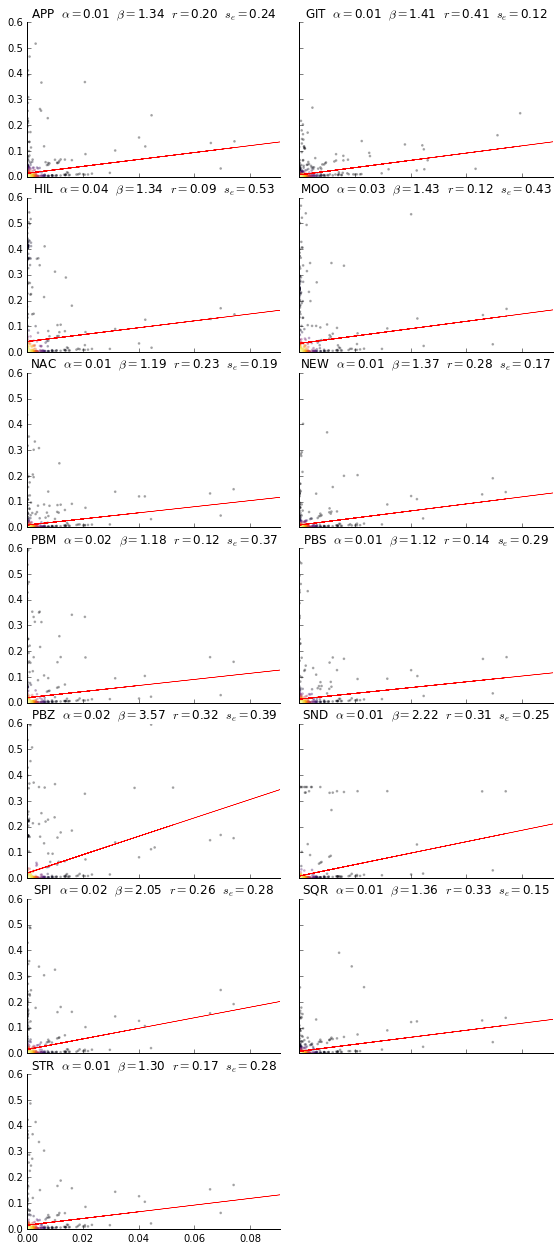

In [6]:
%%time
from matplotlib.colors import LogNorm
import random

technique_list = Parser.list_techniques()
nrow = 7
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(cm2inch(20), cm2inch(2*22)))
fig.delaxes(axs[6, 1])
fig.tight_layout()
xlim = (df_tech_list[0]['delta_data']).quantile(0.999) # Remove the 0.01% outliers

for i, ax in enumerate(fig.axes):
    
    df = df_tech_list[i]
    # If there are too many points to handle, first we draw all of them in black (alpha),
    # then subsample the space, perform kde, and draw the colored subsample
    # over the original points
    if len(df) > 10000:
        matrix = df[['delta_data', 'delta_vis']].T.as_matrix()
        ax.scatter(matrix[0], matrix[1], color='k', s=1, alpha=.2)

        sample_size = 10000
        matrix = df[['delta_data', 'delta_vis']].sample(sample_size).T.as_matrix()
        dens = stats.gaussian_kde(matrix)
        dens_pt = dens(matrix)
        colours = make_colors(dens_pt, 'inferno')
        ax.scatter(matrix[0], matrix[1], color=colours, s=3, alpha=.05)
    else:        
        matrix = df[['delta_data', 'delta_vis']].T.as_matrix()
        dens = stats.gaussian_kde(matrix)
        dens_pt = dens(matrix)
        colours = make_colors(dens_pt, 'inferno')
        ax.scatter(matrix[0], matrix[1], color=colours, s=3, alpha=.25)
    
    # Compute linear regression and draw regression line 
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['delta_data'], df['delta_vis'])

    line = np.poly1d([slope, intercept])(df['delta_data'])
    ax.plot(df['delta_data'], line, 'r-', lw=.5)
    
    title = technique_list[i].upper()
    title += r"  $\alpha = $" + "{0:.2f}".format(intercept)
    title += r"  $\beta = $" + "{0:.2f}".format(slope)
    title += r"  $r = $" + "{0:.2f}".format(r_value)
    title += r"  $s_e = $" + "{0:.2f}".format(std_err)
    ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='x', which='both', top='off')
    ax.tick_params(axis='y', which='both', right='off')
    ax.set_xlim(xmin=0, xmax=xlim)
    ax.set_ylim(ymin=0)    
    
fig.savefig(dataset_id + '_scatter.png', format='png', dpi=800)